<a href="https://colab.research.google.com/github/Adane-Buni-Irkiso/AquaCropvis/blob/main/AquaCropvis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading packages and function codes

In [87]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def read_aquacrop_output(file_path, columns):
    """Reads AquaCrop .OUT files and returns a combined DataFrame"""
    with open(file_path, encoding='latin-1') as file:
        lines = file.readlines()

    runs = []
    current_run = []

    for line in lines:
        if line.startswith('** Run number:'):
            if current_run:
                runs.append(current_run)
                current_run = []
        elif line.strip() and not line.startswith(('Day', 'AquaCrop', 'Soil', 'mm', 'm')) and not line.startswith('   -'):
            parts = line.split()
            if len(parts) >= 5:  # Ensure it's a data line
                current_run.append(parts)

    if current_run:
        runs.append(current_run)

    dfs = []
    for i, run_data in enumerate(runs, 1):
        if not run_data:
            continue

        # Create DataFrame and handle column count mismatch
        df = pd.DataFrame(run_data)
        col_count = min(len(columns), df.shape[1])
        df.columns = columns[:col_count]

        # Convert numeric columns
        for col in df.columns:
            if col != 'Stage':  # Stage could be text
                df[col] = pd.to_numeric(df[col], errors='coerce')

        df['Run'] = i
        dfs.append(df)

    return pd.concat(dfs) if dfs else None
#Plots a single variable across all seasons
def plot_var(df, variable, plot_title=None, y_label=None, figsize=(8 , 5)):

    if df is None:
        print("No data available to plot.")
        return

    plt.figure(figsize=figsize)
    for run_num in df['Run'].unique():
        run_data = df[df['Run'] == run_num]
        # Extract start and end year from the 'Year' column for the current run
        # Ensure 'Year' column exists and is not empty
        if 'Year' in run_data.columns and not run_data['Year'].empty:
            start_year = int(run_data['Year'].min())
            end_year = int(run_data['Year'].max())

            # Check if the run is within a single year or spans multiple years
            if start_year == end_year:
                label_text = f'{start_year}'  # Single year format
            else:
                label_text = f'{start_year}/{end_year}'  # Start/end year format
        else:
            # Fallback if 'Year' column is missing or empty
            label_text = f'Season {run_num}'

        plt.plot(run_data['DAP'], run_data[variable], label=label_text)

    plt.xlabel('Days After Sowing (DAP)')
    plt.ylabel(y_label or f'{variable}')
    plt.title(plot_title or f'{variable} Over Time for Each Season')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
#Plots multiple variables for a single season
def plot_multivar(df, run_num, variables, plot_title=None, y_label=None, figsize=(8 , 5)):

    if df is None:
        print("No data available to plot.")
        return

    plt.figure(figsize=figsize)
    run_data = df[df['Run'] == run_num]

    for var in variables:
        if var in run_data.columns:
            plt.plot(run_data['DAP'], run_data[var], label=var)

    plt.xlabel('Days After Sowing (DAP)')
    plt.ylabel(y_label or 'Value')
    plt.title(plot_title or f'Multiple Variables - Season {run_num}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Plot two variables on a shared x-axis with different y-axes for a single season
def plot_dual_axis(df1, var1, df2, var2, run_num, title=None, y1_label=None, y2_label=None, figsize=(8 , 5)):
    """
   Parameters:
    df1 (DataFrame): The first data frame containing var1
    var1 (str): Variable name from df1 for the primary y-axis (left)
    df2 (DataFrame): The second data frame containing var2
    var2 (str): Variable name from df2 for the secondary y-axis (right)
    run_num (int): The run/season number to plot
    title (str): Plot title
    y1_label (str): Label for primary y-axis (left)
    y2_label (str): Label for secondary y-axis (right)
    figsize (tuple): Figure size as (width, height)
    """
    if df1 is None or df2 is None:
        print("One or both dataframes are not available.")
        return

    # Get data for the specified run from both dataframes
    run_data1 = df1[df1['Run'] == run_num]
    run_data2 = df2[df2['Run'] == run_num]

    if run_data1.empty or run_data2.empty:
        print(f"No data available for run {run_num} in one or both dataframes.")
        return

    # Get season year for the title from df1, handling potential NaNs
    season_text = f"Season {run_num}" # Default text
    if 'Year' in run_data1.columns and not run_data1['Year'].empty:
        # Find the first non-null year in the column and convert to int
        valid_years = run_data1['Year'].dropna().astype(int)
        if not valid_years.empty:
            start_year = valid_years.iloc[0]
            # Optionally, find the last valid year for a range
            end_year = valid_years.iloc[-1]
            if start_year == end_year:
                 season_text = f"Season {run_num} ({start_year})"
            else:
                 season_text = f"Season {run_num} ({start_year}-{end_year})"

    # Create the figure and primary axis
    fig, ax1 = plt.subplots(figsize=figsize)

    # Plot first variable on primary axis
    ax1.set_xlabel('Days After Sowing (DAP)')
    ax1.set_ylabel(y1_label or var1,color='forestgreen')
    ax1.plot(run_data1['DAP'], run_data1[var1],label=var1,color='forestgreen')
    ax1.tick_params(axis='y')

    # Create the secondary axis
    ax2 = ax1.twinx()

    # Plot second variable on secondary axis
    ax2.set_ylabel(y2_label or var2,color='brown')
    ax2.plot(run_data2['DAP'], run_data2[var2],label=var2,color='brown')
    ax2.tick_params(axis='y')

    # Add title
    plt.title(title or f'{var1} and {var2} - {season_text}')

    # Add combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.grid(True)
    plt.tight_layout()
    plt.show()
# Note: Replace file paths with actual paths when using this code

# Example 1: Water balance components for single or multiple cropping seasons

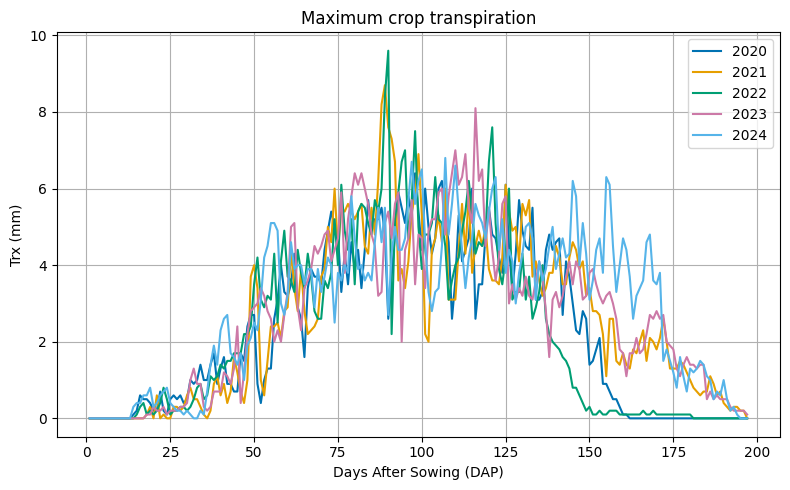

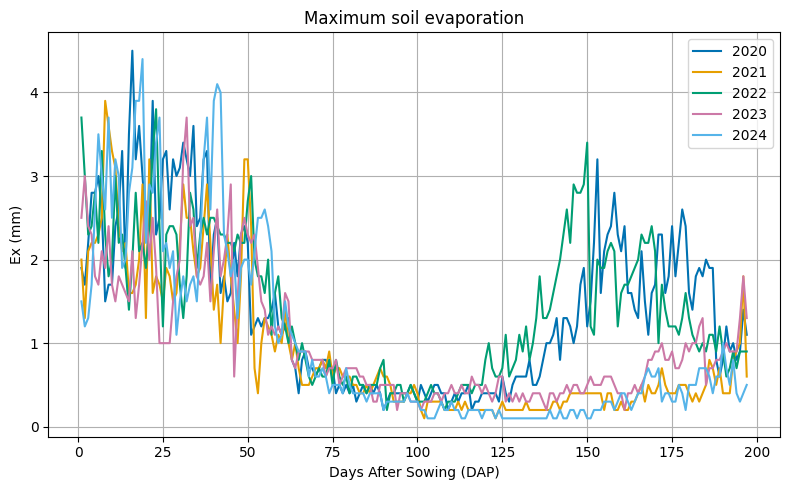

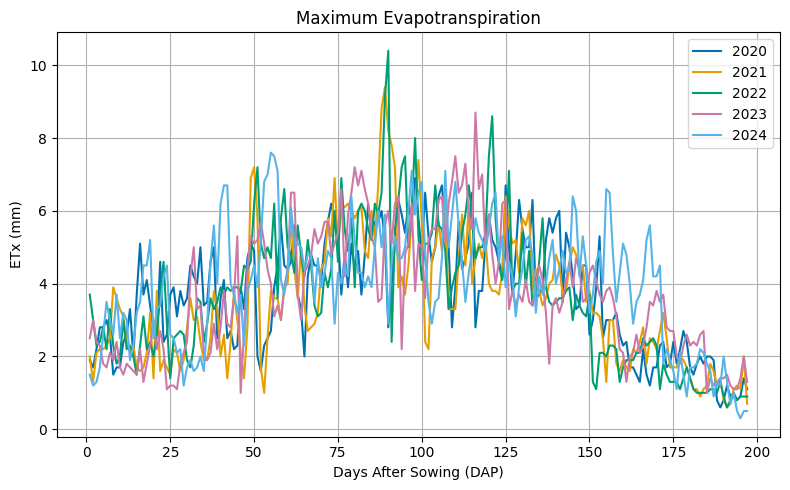

In [91]:
wabal_columns = ['Day', 'Month', 'Year', 'DAP', 'Stage', 'WCTot', 'Rain', 'Irri', 'Surf',
                'Infilt', 'RO', 'Drain', 'CR', 'Zgwt', 'Ex', 'E', 'E/Ex', 'Trx', 'Tr',
                'Tr/Trx', 'ETx', 'ET', 'ET/ETx']
wabal_df = read_aquacrop_output('Example_Wabal.OUT', wabal_columns) # Replace the file path ending with Wabal.OUT
plot_var(wabal_df, 'Trx', 'Maximum crop transpiration', 'Trx (mm)')
plot_var(wabal_df, 'Ex', 'Maximum soil evaporation', 'Ex (mm)')
plot_var(wabal_df, 'ETx', 'Maximum Evapotranspiration', 'ETx (mm)')
# LEGEND
# DAP          : Days after planting
# Stage        : 0: before/after planting
# Stage        : 1: emergence or transplant recovery
# Stage        : 2: vegetative stage
# Stage        : 3: flowering
# Stage        : 4: yield formation and ripening
# WCTot        : Water content in total soil profile
# Rain         : Rainfall
# Irri         : Water applied by irrigation
# Surf         : Stored water on soil surface between bunds
# Infilt       : Infiltrated water in soil profile
# RO           : Surface runoff
# Drain        : Water drained out of the soil profile
# CR           : Water moved upward by capillary rise
# Zgwt         : Depth of the groundwater table (-9.90 if absent)
# Ex           : Maximum soil evaporation
# E            : Soil evaporation
# E/Ex         : Relative soil evaporation (100 E/Ex)
# Trx          : Maximum crop transpiration
# Tr           : Total transpiration of crop and weeds
# Tr/Trx       : Relative transpiration (100 Tr/Trx)
# ETx          : Evapotranspiration maximale
# ET           : Evapotranspiration
# ET/ETx       : Evapotranspiration relative (100 ET/ETx)

# Example 2: Soil Water Content at a specific layer for single or multiple cropping seasons

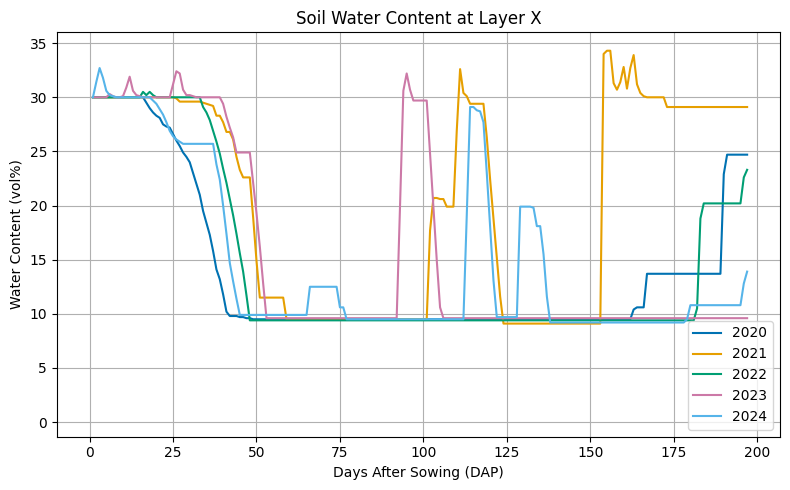

In [99]:
wc_columns = ['Day', 'Month', 'Year', 'DAP', 'Stage', 'WC1(vol%)', 'WC2(vol%)', 'WC3(vol%)',
             'WC4(vol%)', 'WC5(vol%)', 'WC6(vol%)', 'WC7(vol%)', 'WC8(vol%)', 'WC9(vol%)',
             'WC10(vol%)', 'WC11(vol%)', 'WC12(vol%)']
wc_df = read_aquacrop_output('Example_CompWC.OUT', wc_columns)# Replace the file path ending with CompWC.OUT
plot_var(wc_df, 'WC2(vol%)', 'Soil Water Content at Layer X', 'Water Content (vol%)')

##  LEGEND
# DAP          : Days after planting
# Stage        : 0: before/after planting
# Stage        : 1: emergence or transplant recovery
# Stage        : 2: vegetative stage
# Stage        : 3: flowering
# Stage        : 4: yield formation and ripening
# WC1(vol%) - WC12(vol%) : Water Content (WC) at different soil layers (1,2,3,4,5.....)

# Example 4 - Soil water content comparison at multiple soil layers per one cropping season

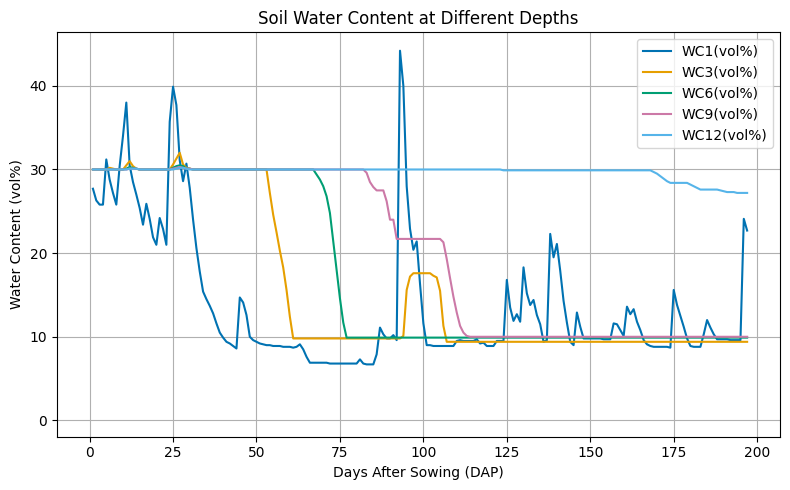

In [93]:

soil_layers = ['WC1(vol%)', 'WC3(vol%)', 'WC6(vol%)', 'WC9(vol%)', 'WC12(vol%)']
plot_multivar(wc_df, 4, soil_layers, 'Soil Water Content at Different Depths', 'Water Content (vol%)')# # Change the season/run number as desired(1,2,3.....corresponding to consecutive years (2015,2016,2017))

# Example 5: Water content in total soil profile for single or multiple seasons

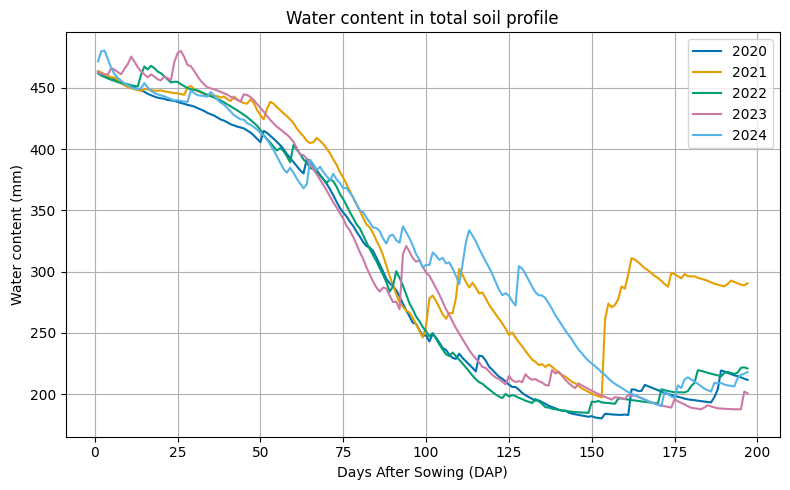

In [94]:

prof_columns = ['Day', 'Month', 'Year', 'DAP', 'Stage', 'WCTot', 'Wr(Zx)',
           'Z', 'Wr', 'Wr(SAT)', 'Wr(FC)', 'Wr(exp)', 'Wr(sto)',
           'Wr(sen)', 'Wr(PWP)']
prof_df = read_aquacrop_output('Example_Prof.OUT', prof_columns) # Replace the file path ending with Prof.OUT
plot_var(prof_df, 'WCTot', 'Water content in total soil profile', 'Water content (mm)')

# Legend

# DAP          : Days after planting
# Stage        : 0: before/after planting
# Stage        : 1: emergence or transplant recovery
# Stage        : 2: vegetative stage
# Stage        : 3: flowering
# Stage        : 4: yield formation and ripening
# WCTot        : Water content in total soil profile (layer: 0.00 - 1.55 m)
# Wr(Zx)       : Water content in maximum effective root zone (Zx = 1.50 m)
# Z            : Effective rooting depth
# Wr           : Water content in effective root zone
# Wr(Sat)      : Water content in effective root zone if saturated
# Wr(FC)       : Water content in effective root zone at field capacity
# Wr(exp)      : Water content in effective root zone at upper threshold for leaf expansion
# Wr(sto)      : Water content in effective root zone at upper threshold for stomatal closure
# Wr(sen)      : Water content in effective root zone at upper threshold for early canopy senescence
# Wr(PWP)      : Water content in effective root zone at permanent wilting point

# Example 6: Crop growth outputs for single or multiple seasons

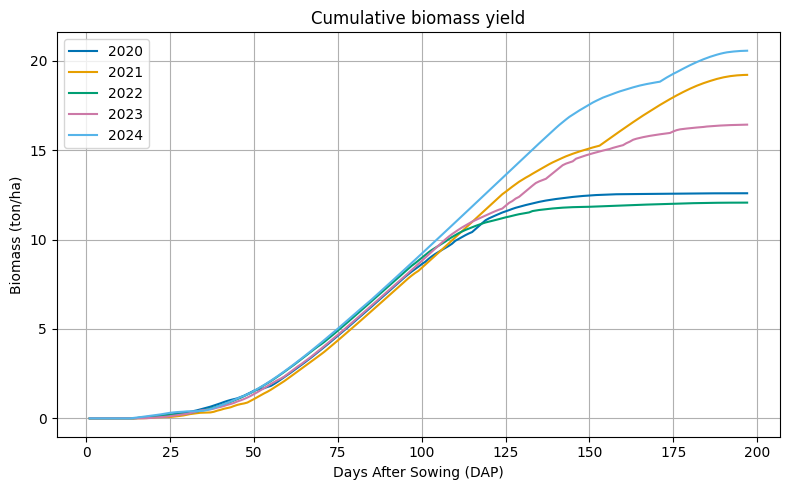

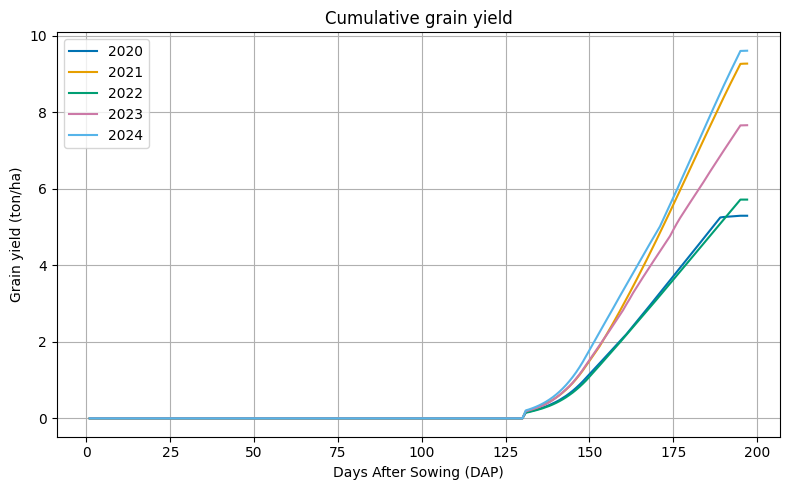

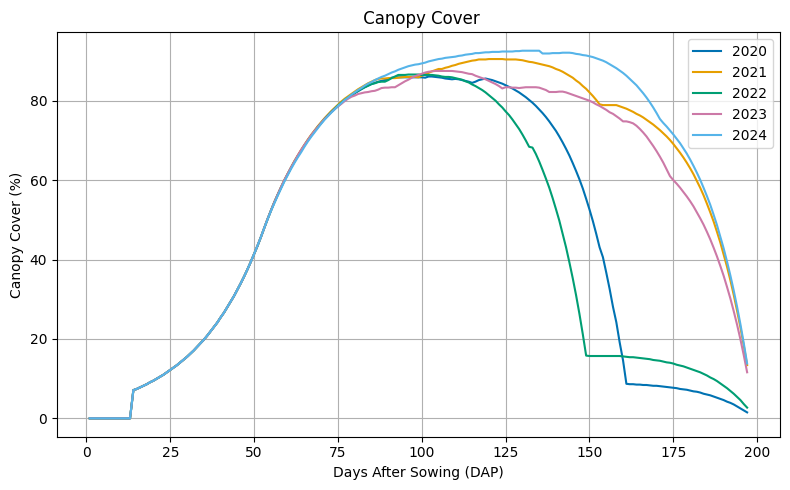

In [95]:

crop_columns = ['Day', 'Month', 'Year', 'DAP', 'Stage', 'GD', 'Z', 'StExp', 'StSto', 'StSen',
               'StSalt', 'StWeed', 'CC', 'CCw', 'StTr', 'Kc(Tr)', 'Trx', 'Tr', 'TrW', 'Tr/Trx',
               'WP', 'Biomass', 'HI', 'YieldPart', 'Brelative', 'WPet']
crop_df = read_aquacrop_output('Example_Crop.OUT', crop_columns)# Replace the file path ending with Crop.OUT
plot_var(crop_df, 'Biomass', 'Cumulative biomass yield', 'Biomass (ton/ha)')
plot_var(crop_df, 'YieldPart', 'Cumulative grain yield', 'Grain yield (ton/ha)')
plot_var(crop_df, 'CC', ' Canopy Cover', 'Canopy Cover (%)')
# Legend

# DAP          : Days after planting
# Stage        : 0: before/after planting
# Stage        : 1: emergence or transplant recovery
# Stage        : 2: vegetative stage
# Stage        : 3: flowering
# Stage        : 4: yield formation and ripening
# GD           : Growing degrees
# Z            : Effective rooting depth
# StExp        : Percent water stress reducing leaf expansion
# StSto        : Percent water stress inducing stomatal closure
# StSen        : Percent water stress triggering early canopy senescence
# StSalt       : Percent salinity stress
# StWeed       : Relative cover of weeds
# CC           : Green total Canopy Cover of crop and weeds
# CCw          : Green crop Canopy Cover in weed infested field
# StTr         : Percent temperature stress affecting crop transpiration
# Kc(Tr)       : Crop coefficient for transpiration
# Trx          : Maximum total transpiration of crop and weeds
# Tr           : Total transpiration of crop and weeds
# TrW          : Crop transpiration in weed infested field
# Tr/Trx       : Relative total transpiration of crop and weeds (100 Tr/Trx)
# WP           : Crop water productivity adjusted for CO2, soil fertility and products synthesized
# Biomass      : Cumulative crop biomass
# HI           : Harvest Index adjusted for failure of pollination, inadequate photosynthesis and water stress
# Yield Part   : Crop yield (HI x Biomass)
# Brelative    : Relative biomass (Reference: no water, no soil fertility, no soil salinity stress, no weed infestation)
# WPet         : ET Water productivity for yield part (kg yield produced per m3 water evapotranspired)

# Example 7: Visualizing relationships between multiple variables on a single plot

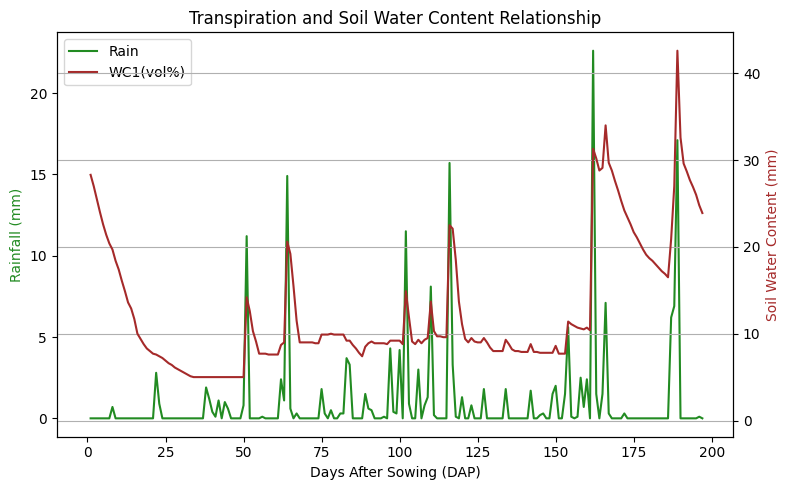

In [96]:
# Example 8: Cross-dataframe dual-axis plot - Transpiration and Soil Water Content
# This plots variables from two different dataframes on the same graph
plot_dual_axis(

    wabal_df, 'Rain',           # water balance component
    wc_df, 'WC1(vol%)',       # Specific layer soil moisture content
    # prof_df,'WCTot',            # Root zone or total soil profile
    run_num=1,                  # Change the season/run number as desired
    title='Transpiration and Soil Water Content Relationship',
    y1_label='Rainfall (mm)',
    y2_label='Soil Water Content (mm)')